# Doordash Business Analysis and Prediction

## Task:

When a consumer plces an order on DoorDash, we show the expected time of
delivery. It is very important for DoorDash to get this information correct,
as it has a big impact on consumer experience. In this exercise, you will
perform exploratory analysis, data preparation, and statistical modelling to
predict the estimated time take for a delivery.

For a given delivery, you must predict the total delivery duration in
seconds, from start to end.

## Data Description

The file in `~/datasets/historical_data.csv` contains a subset of deliveries
received at DoorDash in early 2015 in a subset of the cities. Each row in
this file corresponds to one unique delivery instance. We have added noise to
 the dataset to obfuscate certain business details. Each column corresponds
 to a feature as explained below. Note all money values given in the data are
  in cents and all time duration values are given in seconds.

The target value to predict is the total sconds value betweeen `created_at`
and `actual_delivery_time`.

### Columns:

#### Time Features

- `market_id`: A city/region in which DoorDash operates, e.g., Los Angeles,
given in the data as an id.
- `created_at`: Timestamp in UTC when the order was submitted by the consumer
 to DoorDash.
 - `actual_delivery_time`: Timestamp in UTC when the order was delivered to
 the consumer

#### Store Features

- `store_id`: An id representing the restaurant the order was submitted for.
- `store_primary_category`: Cuisine category of the restaurant, e.g.,
Italian, asian
- `order_protocol`: A store can receive orders from DoorDash through many
modes. This field represents an id denoting the protocol.

#### Order Features

- `total_items`: total number of items in the order
- `subtotal`: total value of the order submitted (in cents)
- `num_distinct_items`: number of distinct items included in the order
- `min_item_price`: price of the item with the least cost in the order (in
cents)
- `max_item_price`: price of the item with the highest cost in the order (in
cents)

#### Market Features

DoorDash being a marketplace, we have more information on the state of
marketplace when the order is placed, that can be used to estimate delivery
time. The following features are values at the time of `created_at` (order
submission time in UTC):
- `total_onshift_dashers`: Number of available dashers who are within 10
miles of the store at the time of order creation.
- `total_busy_dashers`: Subset of above `total_onshift_dashers` who are
currently working on an order
- `total_outstanding_orders`: Number of orders within 10 miles of this order
that are currently being processed.

#### Predictions From Other Models

We have predictions from other models for various stages of the delivery
process that we can use:
- `estimated_order_place_duration`: Estimated time for the restaurant to
receive the order from DoorDash (in seconds)
- `estimated_store_to_consumer_driving_duration`: Estimated travel time
between the store and customers (in seconds)

## Practicalities

Build a model to predict the total delivery duration in seconds (as defined
above). Feel free to generate additional features from the given data to
improve model performance. Explain:
- model's used,
- how you evaluated your model performance on the historical data,
- any data processing you performed on the data,
- feature engineering choices you made,
- other information you would like to share to your modeling approach.

There are no restrictions on package and library usage insofar as they are
open source.

# Begin

# 1. Data Exploration
## 1.1 Initial Exploration

In [169]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pandas.core.dtypes.common import is_integer_dtype

In [170]:
df = pd.read_csv(r'C:\Users\Shamel\PycharmProjects\Doordash_Businessanalysis'
                 u'\datasets\historical_data.csv')
df.info()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Shamel\AppData\Local\Temp\ipykernel_16712\1291405994.py:2: SyntaxWarning: invalid escape sequence '\d'
  u'\datasets\historical_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In the above cell, we see that the total number of rows are 197,428.
Additionally, our dataset consists of 15 columns. 6 of thesecolumns are cast as float64, 7 of these are cast as int64 and 3 are objects.

The three columns that are objects are:
- `created_at` which is a timestamp in UTC;
- `actual_delivery_time` which is also a timestamp in UTC;
- `store_primary_catergory` which is a categorical variable.

The two timestamp columns will be changed to a datetime object using the
datetime library in the cell below.

In [171]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

## 1.2 Missing Data Exploration

In [172]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In the above cell, I sum the columns for their missing and null values. We
see the following columns with missing or null values:

- `market_id`: which is the city or region of operation (987 values missing
or null);
- `actual_delivery_time`: timestamp in UTC when the order was delivered.
- `store_primary_category`: which is the cuisine category of the vendor (4760
 values missing or null).
- `order_protocol`: which is the mode through which orders were received (995
 values missing or null).
- `total_onshift_dashers`: total number of dashers that were on shift when
 the order was placed.
- `total_busy_dashers`: a subset of `total_onshift_dashers` that were not
  available when the order was placed.
- `total_outstanding_orders`: number of orders within 10 miles of the current
 order being processed when the current order was placed.
- `estimated_store_to_consumer_driving_duration`: estimated travel time
between store and customer (in seconds).
- `total_delivery_duration`: which is our target variable.

In [173]:
missing_data_prop = 100 * (df.isna().sum() / len(df))
missing_data_prop.map(lambda x: f'{x:.3f}%')

market_id                                       0.500%
created_at                                      0.000%
actual_delivery_time                            0.004%
store_id                                        0.000%
store_primary_category                          2.411%
order_protocol                                  0.504%
total_items                                     0.000%
subtotal                                        0.000%
num_distinct_items                              0.000%
min_item_price                                  0.000%
max_item_price                                  0.000%
total_onshift_dashers                           8.237%
total_busy_dashers                              8.237%
total_outstanding_orders                        8.237%
estimated_order_place_duration                  0.000%
estimated_store_to_consumer_driving_duration    0.266%
dtype: object

In the above code block, we map the percentage of missing data of each column
 relative to the length of the dataset. This calculation will inform our
 strategy on handling missing data in Section yah.

## 1.3 Feature Distribution Exploration

First, we will plot the distribution of all our features to see how the data
is distributed. This will inform our strategy on data handling for analysis

Firstly, we will drop the 7 rows where our target variable is missing. These
constitute about 0.004% of our dataset, which is a neglible amount and will
not affect our overall analysis or model.

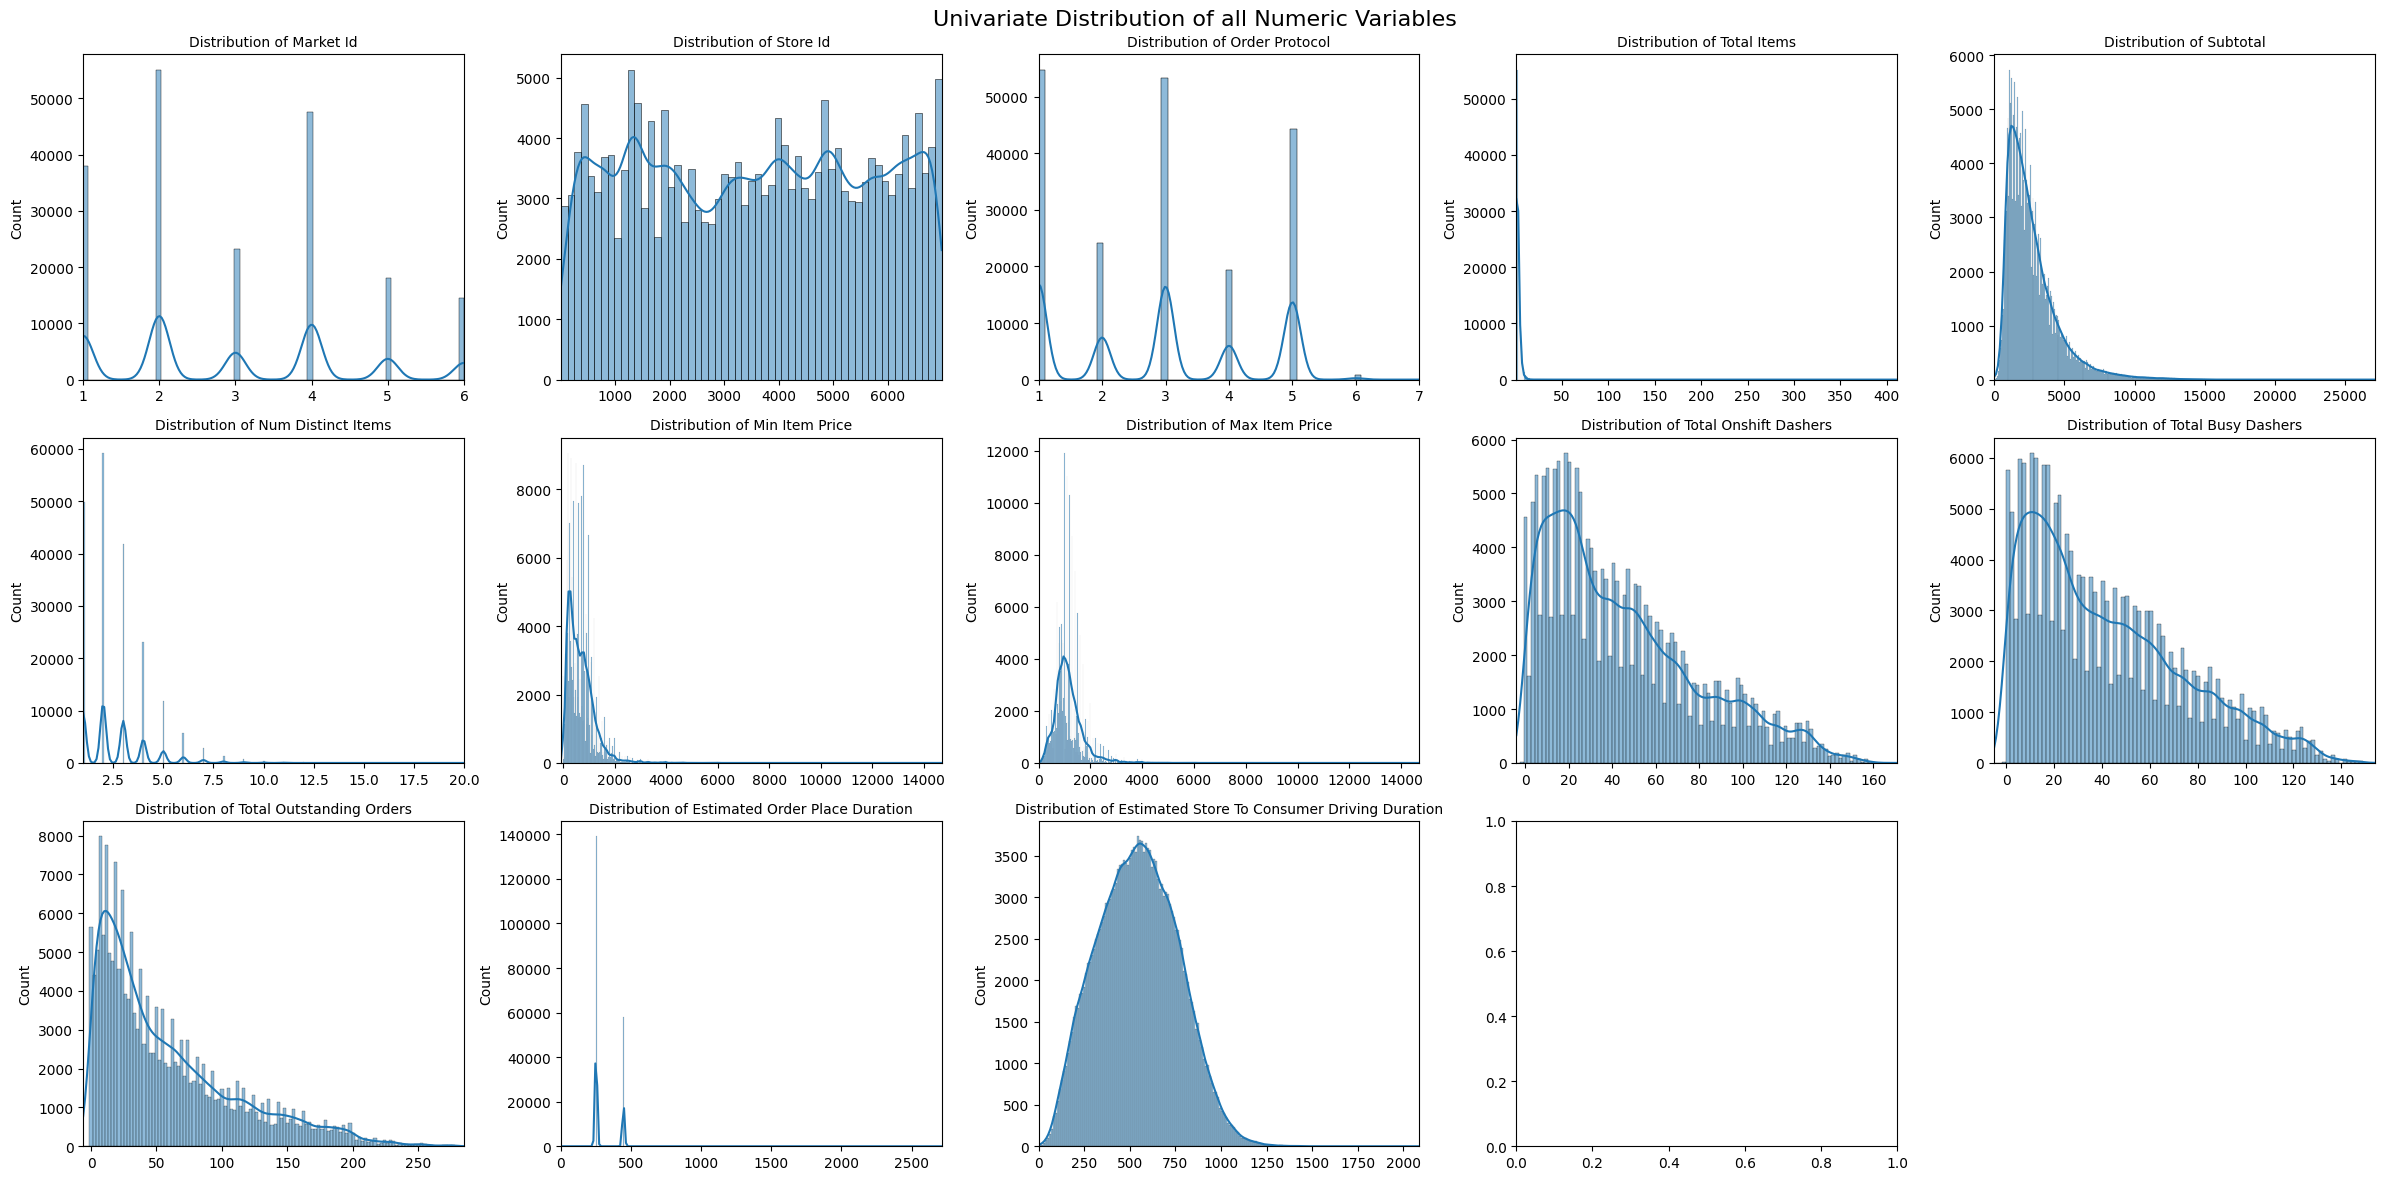

In [174]:
numeric_cols = df.select_dtypes('number').columns

fig, axes = plt.subplots(nrows=3,
                         ncols=5,
                         figsize=(24, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col],
                 kde=True,
                 ax=axes[i])
    axes[i].set_xlim(df[col].min(), df[col].max())
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}',
                      fontsize=10)
    axes[i].set_xlabel('')

axes[-1].set_visible(False)
plt.suptitle("Univariate Distribution of all Numeric Variables",
             fontsize=16)
plt.tight_layout()
plt.show()

#### Categorical Columns
`market_id`: The city/region ID ranges from 1-6. The data shows us that most
orders come from region 2, followed by 4, and 1.

`order_protocol`: The order protocol used ranges from 1-7, with 1, 3 and 5
being the most used protocol.

#### Continuous Columns
`total_items`: The total items range from 0 to over 400, with most of the
items being closer to 0. Due to the large range, and obvious presence of
outliers, this data is highly skewed and right tailed.

`subtotal`: The subtotal ranges from 0 dollars to over 25,000 dollars from
what we see in the graph, and it is normally distributed. This data is also
highly skewed and right tailed due to the presence of outliers.

`min_item_price`: The minimum item price ranges from 0 dollars to over 14,000
 dollars. This data is also highly skewed and right tailed due to the
 presence of outliers.

`max_item_price`: This maximum item price ranges from 0 dollars to over 14,
000 dollars. Much like `min_item_price` this data is also highly skewed and
right tailed due to the presence of outliers. This data is also associated
with the aforementioned column, so any adjustments to this data will
inadvertently affect the distribution of `min_item_price` and vice versa.

`total_onshift_dashers`: This number of on-shift dashers ranges from 0
available dashers to over 160 available dashers. Although this data is skewed
 and right-tailed, the skew is not as severe as some of our other columns.

`total_busy_dashers`: This number of busy on-shift dashers ranges from 0 busy
 dashers to a little over 140 busy dashers. It follows a very similar
 distribution to `total_onshift_dashers` considering this is a subset of the
 aforementioned column.

`total_outstanding_orders`: The data ranges from 0 outstanding orders to over
 250 outstanding orders. This data is also skewed and right-tailed.

`estimated_order_place_duration`: This is a predicted category. It ranges
from 0 seconds to over 2500 seconds. This data seems to be binomially
distributed and the overall data is right-tailed.

`estimated_store_to_consumer_driving_duration`: This is a predicted category.
 It ranges from 0 seconds to over 2000 seconds.

Considering that our distributions are being heavily influenced by outliers,
we will need to handle these outliers before moving forward, and
re-distribute the data.

# 2. Data Preparation

## 2.1 Feature Engineering

Before we begin with outlier handling and processing our data, we will first
engineer features that can improve our model. Additionally, these engineered
features may be substituted for existing features as they may incorporate
ratios of several features.


In [175]:
df['total_delivery_duration'] = ((df['actual_delivery_time'] -
                                 df['created_at']).dt.total_seconds().astype
                                 (float))

In the above codeblock, we create our target/dependent variable by
subtracting the delivery time from the order creation time. Additionally, we
use the datetime library to display the timedelta in seconds and cast this as
 float.

In [177]:
df['available_dashers_ratio'] = ((df['total_onshift_dashers'] -
                                  df['total_busy_dashers']) /
                                 df['total_onshift_dashers'])

df['busy_dashers_ratio'] = 1 - df['available_dashers_ratio']

In the above codeblock, we create two associated ratios from the dasher
availability columns.

In [178]:
df['restaurant_prep_time'] = df[('estimated_store_to_consumer_driving_duration'
                                 '')] - df['estimated_order_place_duration']
df['non_prep_time'] = (df['estimated_store_to_consumer_driving_duration'] +
                       df['estimated_order_place_duration'])

The difference between `created_at` and `actual_delivery_time` gives us the
`total_delivery_duration` of each order. The difference between this timedelta
 and
`estimated_store_to_consumer_driving_duration` gives us the timedelta from
when the order was created and the driver picked up the items. The difference
 between this new timedelta and `estimated_order_place_duration` gives us the
  time it takes for the restaurant to prepare the meal and for the dasher to
  pick it up. The dasher algorithm is designed as such that the dasher that
  accepts the delivery arrives before the order is ready, so we can count
  this as simply restaurant preparation time.

Another easy way to interpret and model this information is to simply take
the difference between `estimated_store_to-consumer_driving_duration` and
`estimated_order_place_duration` to find the restaurant preparation time.

In [195]:
for col in numeric_cols:
    display(df[col].nunique())

6

6743

7

57

8368

20

2312

2652

172

159

281

98

1336

In [198]:
display(numeric_cols[0])
display(numeric_cols[2])

#Pick up here

'market_id'

'order_protocol'

In [165]:
display(df.describe())

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
count,196441.000000,197428,197421,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05
mean,2.978706,2015-02-04 22:00:09.537962752,2015-02-04 22:48:23.348914432,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,2.908257e+03
min,1.000000,2014-10-19 05:24:15,2015-01-21 15:58:11,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,2015-01-29 02:32:42,2015-01-29 03:22:29,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2.104000e+03
50%,3.000000,2015-02-05 03:29:09.500000,2015-02-05 04:40:41,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2.660000e+03
75%,4.000000,2015-02-12 01:39:18.500000,2015-02-12 02:25:26,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3.381000e+03
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06
std,1.524867,NaN,NaN,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,1.922961e+04


In [166]:
datespan = df['created_at'].max() - df['created_at'].min()
datespan

Timedelta('122 days 00:36:29')

In [167]:
df['order_protocol'].mode()

0    1.0
Name: order_protocol, dtype: float64

In [168]:
df['total_items'].median()

np.float64(3.0)

c### `created_at`

In this column, we see that the earliest order was created in October 2014,
and the latest order was created in February of 2015. This means that our
dataset has a time delta of 122 days, 36 minutes, and 29 seconds. In
production level data, we would require data that is spread out over a
greater delta, preferably over a year or more, to account of seasonal trends
and to provide a more comprehensive prediction. However, for the purpose of
this analysis, we will move forward with the data that we have.

### `order_protocol`
The order protocols being used by restaurants range from 1 to 7, with mode 1
being the most used mode.

### `total_items`
The number of total items ordered ranges from 1 to 411. The max value is
obviously an outlier considering most of the data ranges between 1 and 4
items per order. The average number of items per order are 2.88, and the
modal value is 2. This means that people tend to order between 2 and 3 items
per order.
